In [3]:
!pip install tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 395.5MB 42kB/s 
     |████████████████████████████████| 3.8MB 55.5MB/s 
     |████████████████████████████████| 450kB 56.9MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: tb-nightly 2.1.0a20191108 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: requests 2.21.0
    Uninstalling requests-2.21.0:
      Successfully uninstalled requests-2.21.0
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [27]:
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


In [0]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

def draw_boxes(image, boxes, class_names, scores, min_score=0.65):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(boxes.shape[0]):
    if class_names[i].decode("ascii")=="Car" or class_names[i].decode("ascii")=="Land vehicle" or class_names[i].decode("ascii")=="Truck" or class_names[i].decode("ascii")=="Bus" or class_names[i].decode("ascii")=="Van" or class_names[i].decode("ascii")=="Ambulance":
      if scores[i] >= min_score:
        ymin, xmin, ymax, xmax = tuple(boxes[i])
        display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
        color = colors[hash(class_names[i]) % len(colors)]
        image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
        draw_bounding_box_on_image(
            image_pil,
            ymin,
            xmin,
            ymax,
            xmax,
            color,
            font,
            display_str_list=[display_str])
        np.copyto(image, np.array(image_pil))
  return image

In [26]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img
  
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Image downloaded to /tmp/tmpup1djhwp.jpg.
Found 100 objects.
Inference time:  1.0611562728881836
Inference time:
Image downloaded to /tmp/tmpzh35x8j1.jpg.
Found 100 objects.
Inference time:  1.047597885131836
Inference time:
Image downloaded to /tmp/tmpqm_f5_3q.jpg.
Found 100 objects.
Inference time:  1.049938678741455
Inference time:
Image downloaded to /tmp/tmpuo1ut19g.jpg.
Found 100 objects.
Inference time:  1.0559413433074951
Inference time:


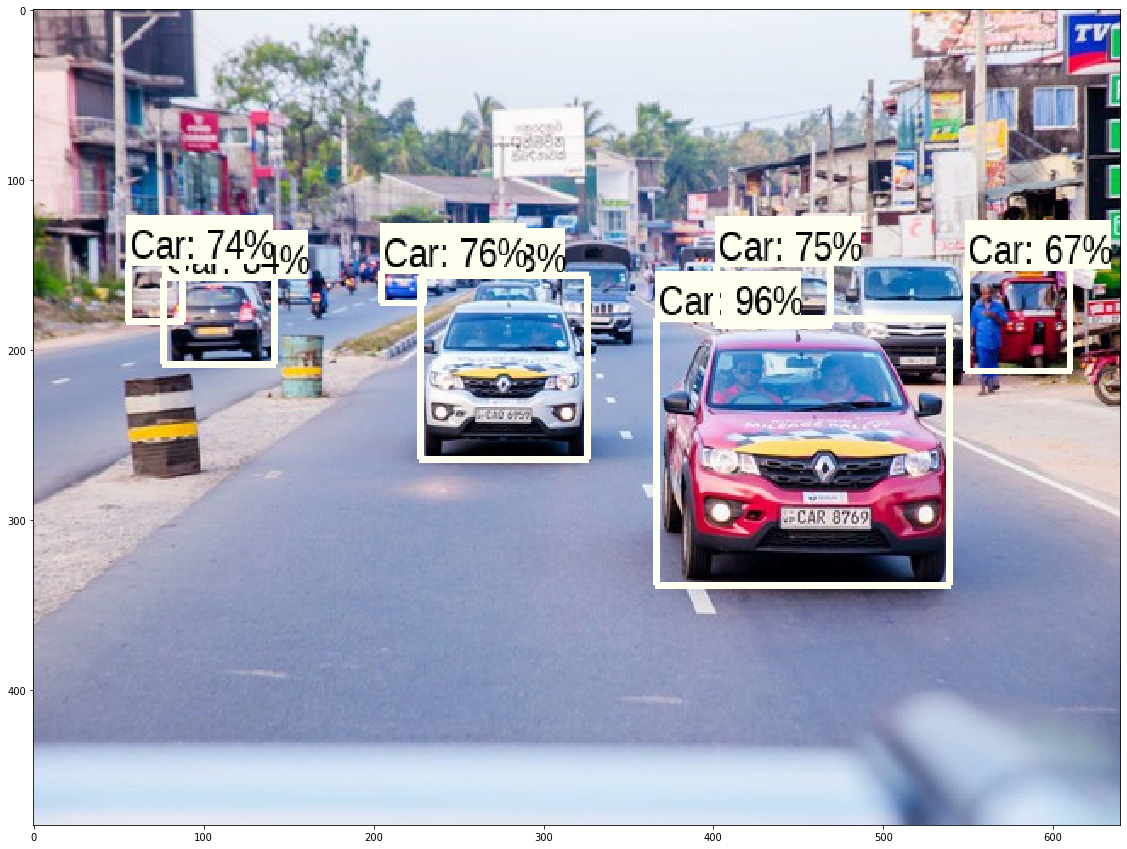

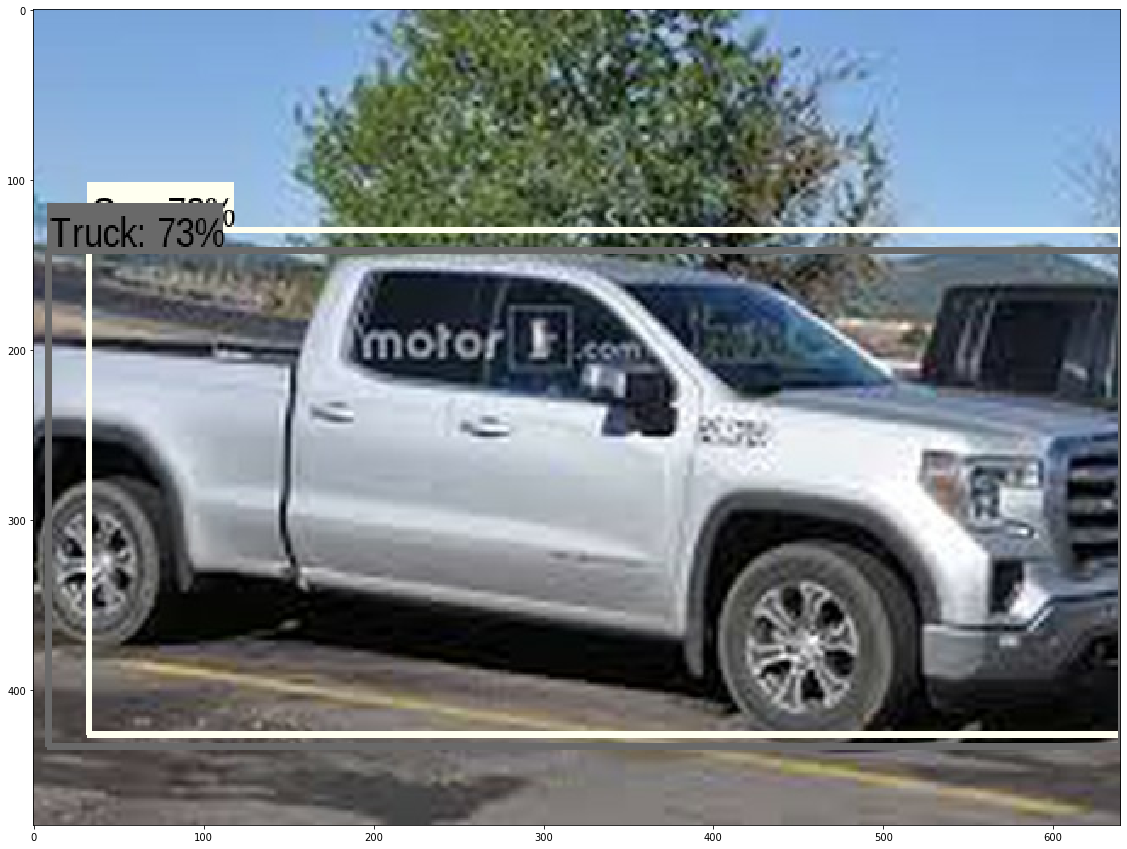

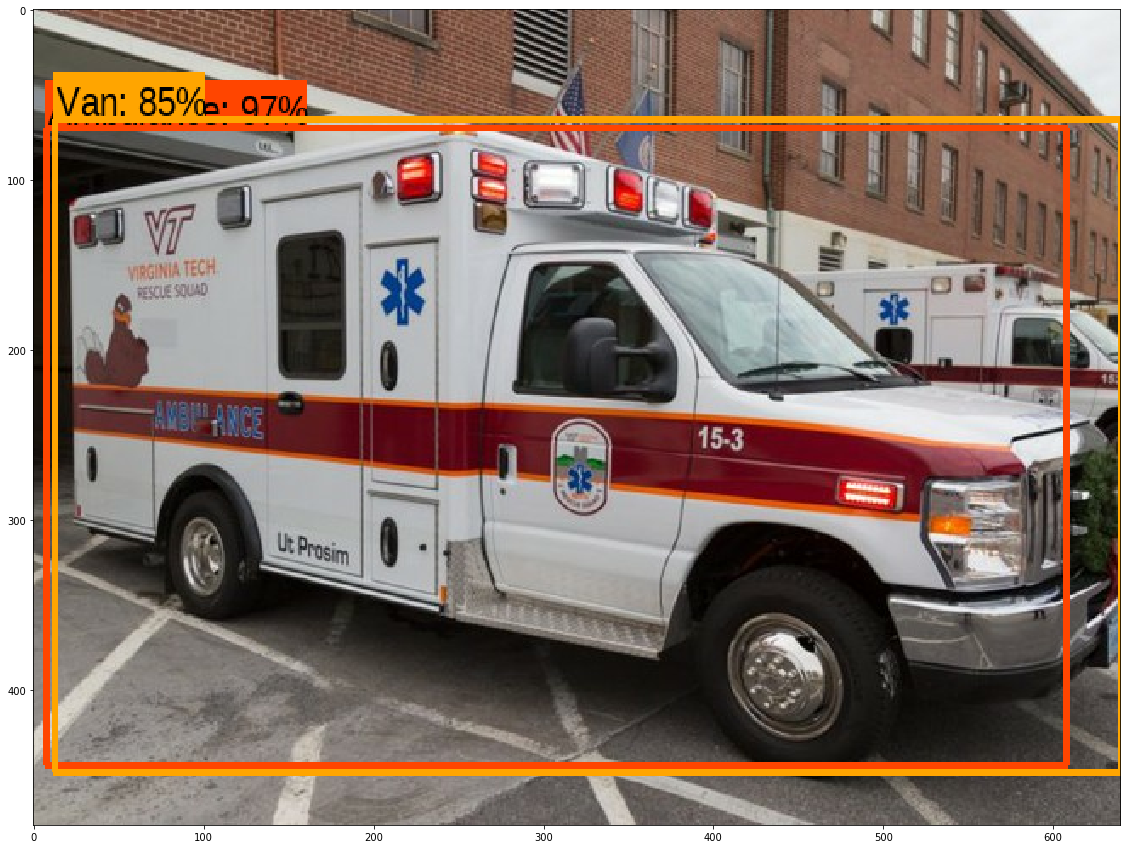

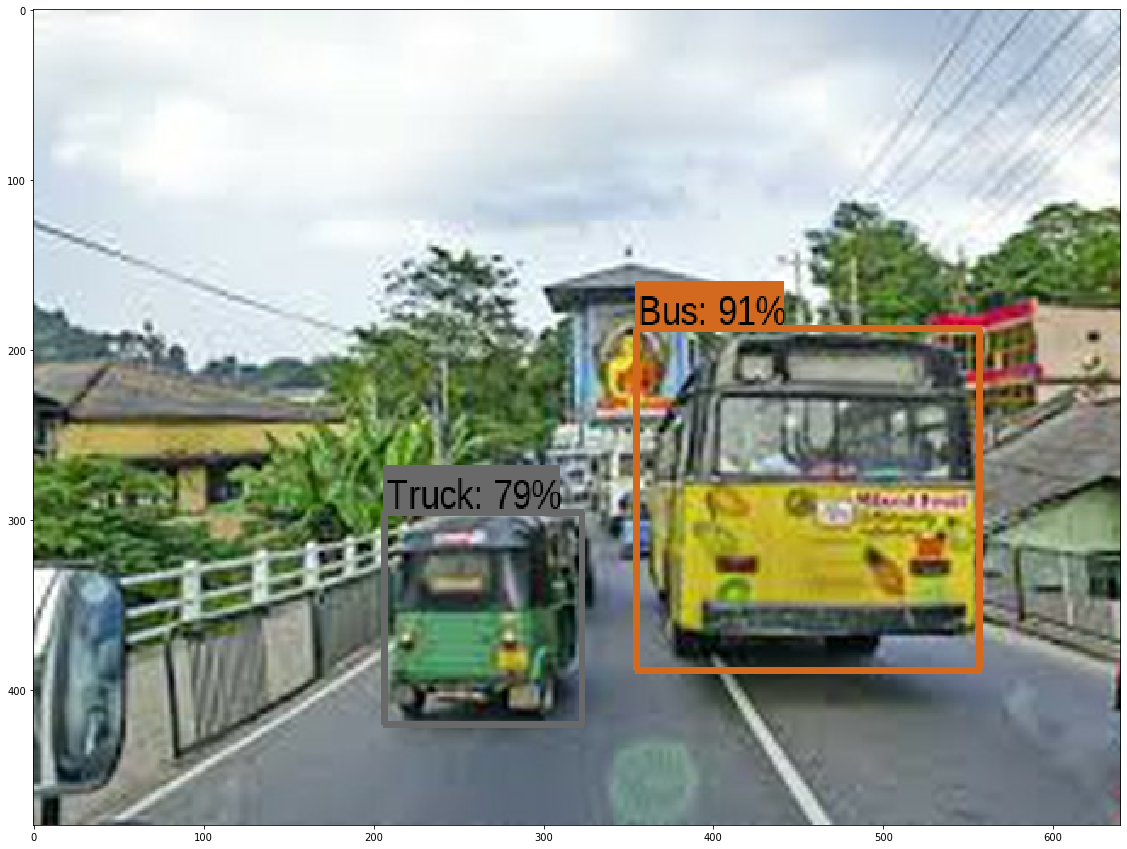

In [48]:
image_urls = ["http://www.renault.lk/img/News/IMG_9185.jpg",
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSNSC9yGfbBVBqaa0XBdIOKNOo43yifoGhSKrSKQP5s4dCqjI15",
              "https://vtnews.vt.edu/content/vtnews_vt_edu/en/articles/2017/12/adm-pd-rescuesquadnewambulance/_jcr_content/article-image.transform/m-medium/image.jpg",
              "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSDxbmKFeB1lFFIp3cStaQ0gfL9ZKeVZ6Lt4ptRFGRKYq6Ct7i5"]

for image_url in image_urls:
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  print("Inference time:")